In [1]:
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py
import random
import cooler
from scipy.interpolate import make_interp_spline
from scipy.signal import argrelextrema    

In [2]:
filepath = './cool/danio.250000_balanced.cool'
c = cooler.Cooler(filepath)

In [3]:
mat = c.matrix(balance=False, sparse=True)[1:2000, 1:2000]
arr = mat.toarray()

/tmp/ipykernel_3783/324882569.py:5: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(arr), cmap='YlOrRd')


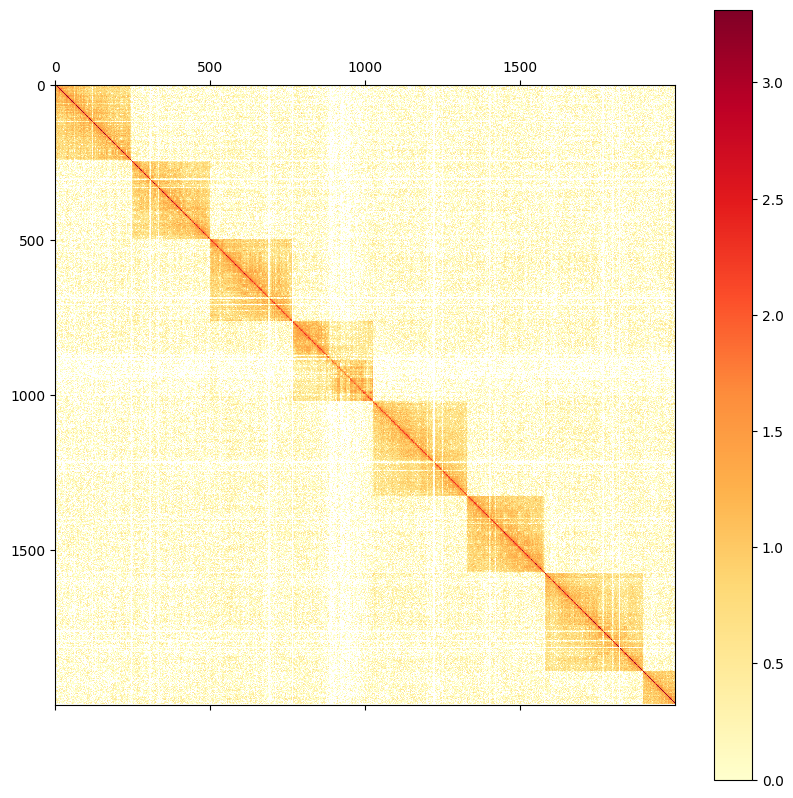

In [4]:
# Так выглядит hi-c карта

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='YlOrRd')
fig.colorbar(im)

In [5]:
# Функция для создания транслокаций в матрице

# mtr -matrix, i - start coordinate, j - end coordinate, k - where to translocate
def translocate(mtr,i,j,k):
    if (j < i) | (j > k):
        print("j must be > i and j < k")
        return
    if i > k:
        j = k + j-i-1
        i,k = k,i
    new_rows = np.vstack([mtr[:i,:], mtr[k:k+j-i+1,:], mtr[j+1:k,:], mtr[i:j+1,:], mtr[k+j-i+1:,]]) # change rows
    translocated = np.hstack([new_rows[:,:i], new_rows[:,k:k+j-i+1], new_rows[:,j+1:k], new_rows[:,i:j+1], new_rows[:,k+j-i+1:]])
    # change columns
    return translocated

In [6]:
def sliding_diagonal_sum(matrix, window_size):
    
    rows, cols = matrix.shape
    
    if window_size > rows or window_size > cols:
        raise ValueError("Window size is too large for the matrix")
    
    sums = []
    for i in range(rows - window_size + 1):
        window = matrix[i:i+window_size, i:i+window_size]
        
        center_rows = window.shape[0] // 2
        center_cols = window.shape[1] // 2

    # Разделяем матрицу на четыре части
#    part1 = matrix[:center_rows, :center_cols]
        part2 = window[:center_rows, center_cols:]
#    part3 = matrix[center_rows:, :center_cols]
#    part4 = matrix[center_rows:, center_cols:]
        
        window_sum = np.sum(part2)
        sums.append(window_sum)
    
    return sums

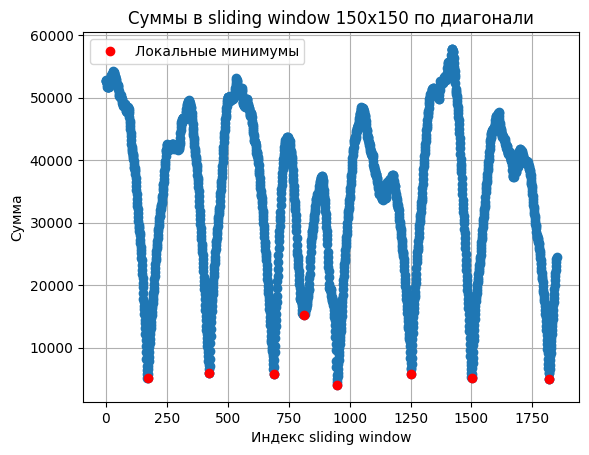

Координаты локальных минимумов: [(0, 0), (247.0, 247.0), (500.0, 500.0), (764.0, 764.0), (888.0, 888.0), (1023.0, 1023.0), (1327.0, 1327.0), (1576.0, 1576.0), (1893.0, 1893.0), (1999, 1999)]


/tmp/ipykernel_3783/1725824684.py:38: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(matrix), cmap='YlOrRd')


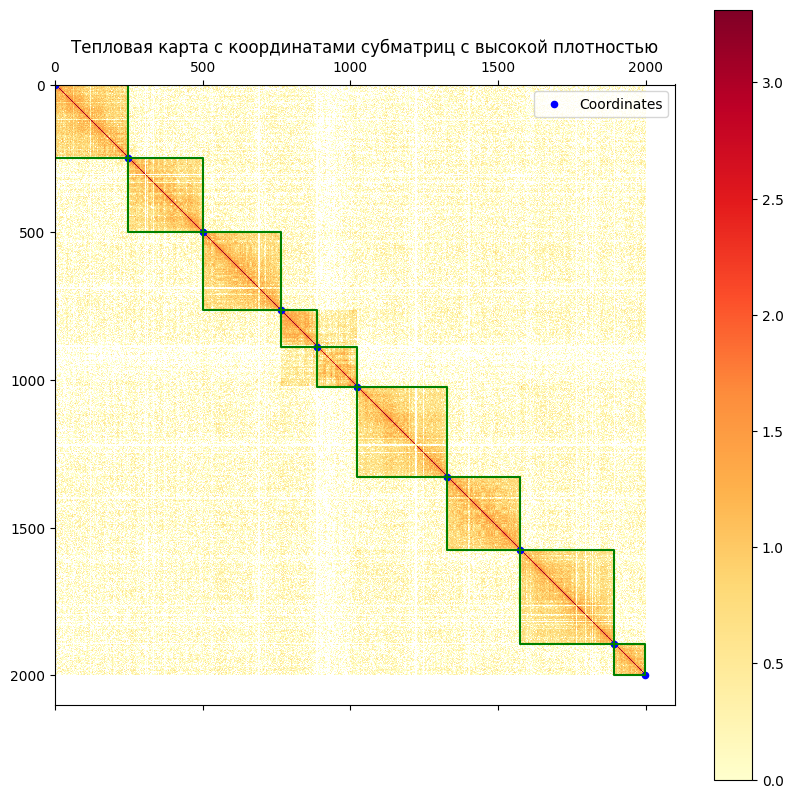

In [7]:
matrix = arr

window_size = 150  # Размер sliding window наерное лучше четное)
N = 70            # Длина отрезка для поиска локальных минимумов

sums = sliding_diagonal_sum(matrix, window_size)

plt.plot(sums, marker='o')
plt.title(f"Суммы в sliding window {window_size}x{window_size} по диагонали")
plt.xlabel("Индекс sliding window")
plt.ylabel("Сумма")
plt.grid(True)

local_min_indices = argrelextrema(np.array(sums), np.less, order=N)[0]
plt.plot(local_min_indices, [sums[i] for i in local_min_indices], "ro", label="Локальные минимумы")
plt.legend()

plt.show()

# Нахождение локальных минимумов для отрезков длины N
num_rows, num_cols = matrix.shape

local_min_indices = argrelextrema(np.array(sums), np.less, order=N)[0]
local_min_coordinates = [(x, x) for x in local_min_indices + window_size/2]
local_min_coordinates.insert(0, (0, 0))
local_min_coordinates.append((num_rows,num_rows))

print("Координаты локальных минимумов:", local_min_coordinates)

# Задание координат точек для отметки
points = local_min_coordinates

# Создание фигуры и осей
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Создание тепловой карты
im = ax.matshow(np.log10(matrix), cmap='YlOrRd')

# Добавление точек с заданными координатами
x, y = zip(*points)
ax.scatter(y, x, color='blue', marker='o', s=20, label='Coordinates')

# Добавление цветовой шкалы
fig.colorbar(im)

# Рисование квадратов между последовательными парами точек
for start, end in zip(points[:-1], points[1:]):
    x_coords = [start[1], end[1], end[1], start[1], start[1]]
    y_coords = [start[0], start[0], end[0], end[0], start[0]]
    ax.plot(x_coords, y_coords, color='green')
    

# Добавление легенды
ax.legend()

# Отображение графика
plt.title('Тепловая карта с координатами субматриц с высокой плотностью')
plt.show()


In [8]:
# Функция для создания инверсий в матрице

def inversion(mtr, i,j):
    rows1 = np.hstack([mtr[:i,:i],np.flipud(mtr[:i, i:j]),mtr[:i, j:]]) #first part, rows to i
    rows2 = np.hstack([np.fliplr(mtr[i:j,:i]), np.flip(mtr[i:j,i:j]), np.fliplr(mtr[i:j, j:])]) # rows from i to j
    rows3 = np.hstack([mtr[j:,:i], np.flipud(mtr[j:, i:j]), mtr[j:,j:]])#
    inv_matr = np.vstack([rows1, rows2, rows3])
    return inv_matr

In [9]:
params = []
for x in range(2):
    i = random.randint(0,len(arr)- 100) #start 
    j= int(i+ random.randrange(20000,500000, 250000)/250000) # size of broken region, step == to bin size
    k = random.randint(j, len(arr)) # end
    mtr = translocate(arr,i,j,k)
    params.append([i,j,k])

In [10]:
# Создадим карту с искуственно созданной транслокацией
mtr = translocate(arr,1100,1200,1700)
# mtr = translocate(arr,1700,1800,1100)

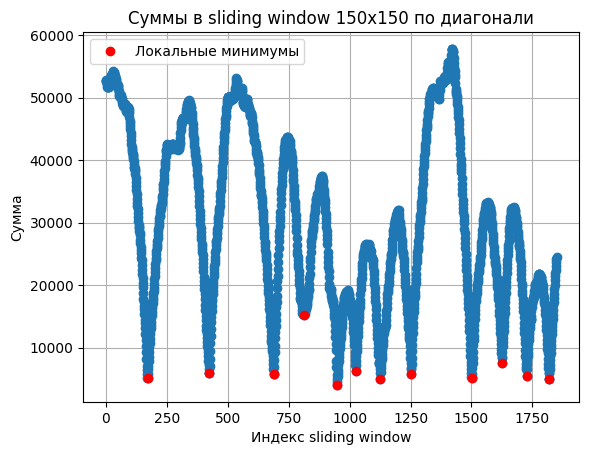

Координаты локальных минимумов: [(0, 0), (247.0, 247.0), (500.0, 500.0), (764.0, 764.0), (888.0, 888.0), (1023.0, 1023.0), (1100.0, 1100.0), (1201.0, 1201.0), (1327.0, 1327.0), (1576.0, 1576.0), (1700.0, 1700.0), (1801.0, 1801.0), (1893.0, 1893.0), (1999, 1999)]


/tmp/ipykernel_3783/1939759695.py:38: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(matrix), cmap='YlOrRd')


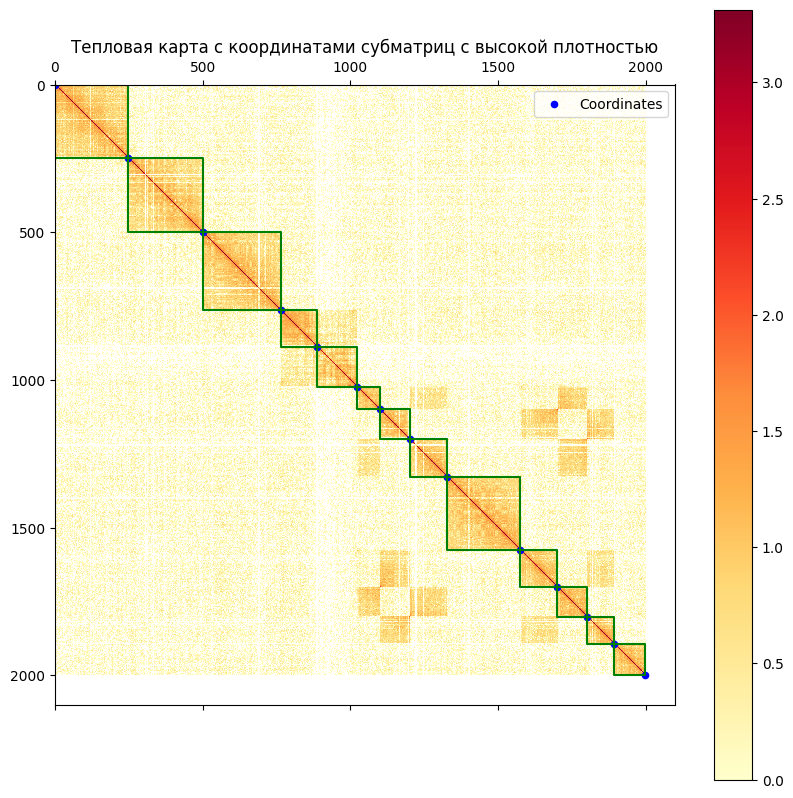

In [11]:
matrix = mtr

window_size = 150  # Размер sliding window наерное лучше четное)
N = 70            # Длина отрезка для поиска локальных минимумов

sums = sliding_diagonal_sum(matrix, window_size)

plt.plot(sums, marker='o')
plt.title(f"Суммы в sliding window {window_size}x{window_size} по диагонали")
plt.xlabel("Индекс sliding window")
plt.ylabel("Сумма")
plt.grid(True)

local_min_indices = argrelextrema(np.array(sums), np.less, order=N)[0]
plt.plot(local_min_indices, [sums[i] for i in local_min_indices], "ro", label="Локальные минимумы")
plt.legend()

plt.show()

# Нахождение локальных минимумов для отрезков длины N
num_rows, num_cols = matrix.shape

local_min_indices = argrelextrema(np.array(sums), np.less, order=N)[0]
local_min_coordinates = [(x, x) for x in local_min_indices + window_size/2]
local_min_coordinates.insert(0, (0, 0))
local_min_coordinates.append((num_rows,num_rows))

print("Координаты локальных минимумов:", local_min_coordinates)

# Задание координат точек для отметки
points = local_min_coordinates

# Создание фигуры и осей
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Создание тепловой карты
im = ax.matshow(np.log10(matrix), cmap='YlOrRd')

# Добавление точек с заданными координатами
x, y = zip(*points)
ax.scatter(y, x, color='blue', marker='o', s=20, label='Coordinates')

# Добавление цветовой шкалы
fig.colorbar(im)

# Рисование квадратов между последовательными парами точек
for start, end in zip(points[:-1], points[1:]):
    x_coords = [start[1], end[1], end[1], start[1], start[1]]
    y_coords = [start[0], start[0], end[0], end[0], start[0]]
    ax.plot(x_coords, y_coords, color='green')
    

# Добавление легенды
ax.legend()

# Отображение графика
plt.title('Тепловая карта с координатами субматриц с высокой плотностью')
plt.show()

In [12]:
# найти точки, на которых график возрастает

def find_points_of_rapid_increase(y_values, growth_threshold=0.1, derivative_threshold=0.1):
    y_values = np.array(y_values)
    derivatives = np.gradient(y_values)
    rapid_increase_points = []

    for i in range(1, len(y_values)):
        if derivatives[i] > derivative_threshold and (y_values[i] - y_values[i-1]) > growth_threshold:
            rapid_increase_points.append(i)

    return rapid_increase_points

In [13]:
def sliding_window_sum(matrix, start_row, start_col, window_size):
    window_sum_list = []

    for col in range(start_col, len(matrix[0]) - window_size + 1):
        window_sum = 0
        for i in range(start_row, start_row + window_size):
            for j in range(col, col + window_size):
                window_sum += matrix[i][j]
        window_sum_list.append(window_sum)

    return window_sum_list

In [14]:
# Начальные координаты и размеры квадрата
start_row = 1100
start_col = 1201
window_size = 101

sliding_window_sum_list = sliding_window_sum(matrix, start_row, start_col, window_size)
# print(result)

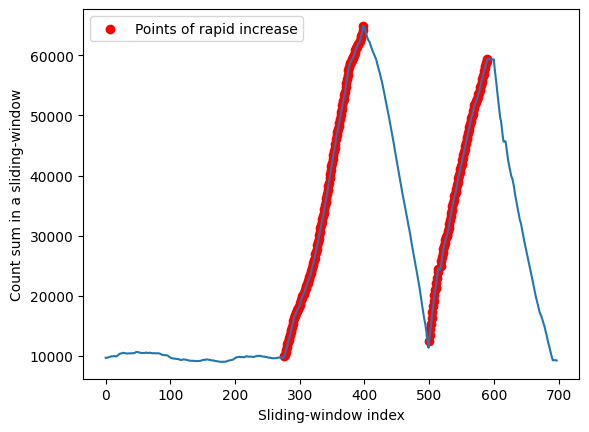

Точки резкого возрастания: [276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 393, 394, 395, 396, 397, 398, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 57

In [15]:
# Пример данных для оси y (ваш список значений)
y_values = sliding_window_sum_list

# Настройки пороговых значений
growth_threshold = 100  # Минимальное значение роста
derivative_threshold = 0.2  # Минимальное значение первой производной

# Находим точки резкого возрастания с учетом пороговых значений
rapid_increase_points = find_points_of_rapid_increase(y_values, growth_threshold, derivative_threshold)
rapid_increase_points_coordinates = [(start_row, start_col + (window_size) + x) for x in rapid_increase_points] # + window_size/2]

# Построение графика
x_values = np.arange(len(y_values))
plt.plot(x_values, y_values, label='')
plt.scatter(rapid_increase_points, np.array(y_values)[rapid_increase_points], color='red', label='Points of rapid increase')
plt.xlabel('Sliding-window index')
plt.ylabel('Count sum in a sliding-window')
#plt.title('Plot of points of rapid increase')
plt.legend()
plt.show()

print("Точки резкого возрастания:", rapid_increase_points)

/tmp/ipykernel_3783/3669018352.py:11: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(matrix), cmap='YlOrRd')


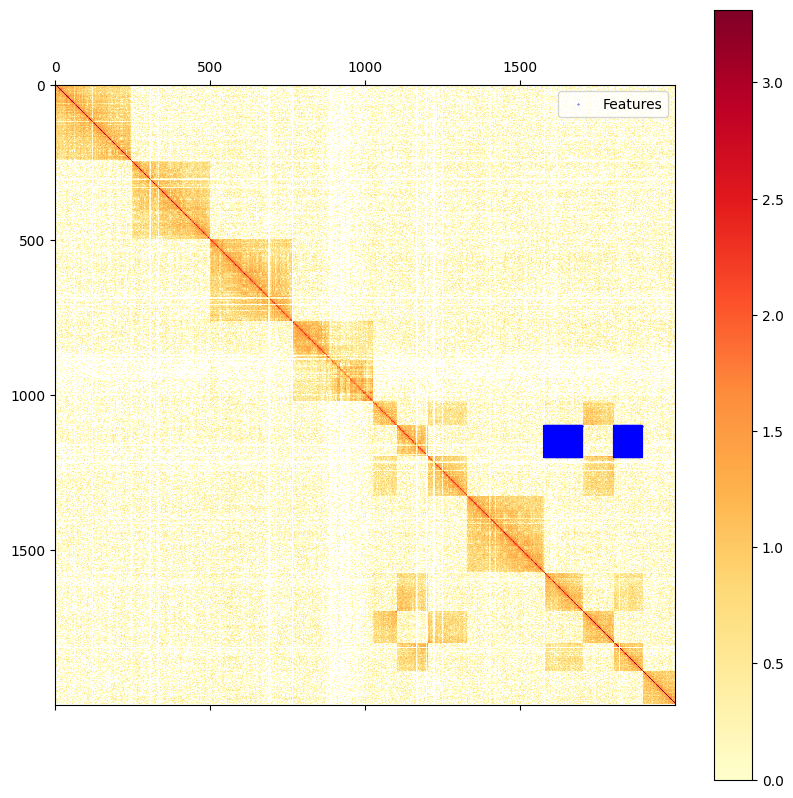

In [16]:
rapid_increase_points_coordinates = [(start_row, start_col + (window_size) + x) for x in rapid_increase_points] # + window_size/2]

# Задание координат точек для отметки
points = rapid_increase_points_coordinates

# Создание фигуры и осей
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# Создание тепловой карты
im = ax.matshow(np.log10(matrix), cmap='YlOrRd')

# Добавление точек с заданными координатами
x, y = zip(*points)
ax.scatter(y, x, color='blue', marker='o', s=0.1, label='Features')

line_length = 101

# Рисование линий из точек вниз
for i in range(len(x)):
    ax.plot([y[i], y[i]], [x[i], x[i] + line_length], color='blue', linestyle='-')

# Добавление цветовой шкалы
fig.colorbar(im)

# Добавление легенды
ax.legend()

# Отображение графика
# plt.title('Тепловая карта с точками')
plt.show()